In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
### SIMULATE DATA ###

def generate_data(idx):

    while True:
        try:
            breaks = np.sort(np.random.choice(len(dates), 2)) 
            length = int(np.random.randint(6, np.diff(breaks) // 15))
        except ValueError:
            continue
        break

    col_amnt = np.random.normal(300, 100, size=length)
    col_date = np.sort(np.random.choice(dates[breaks[0]:breaks[1]],
                                        length, replace=False))
    
    customer_hist = pd.DataFrame({
        'InvoiceDate': col_date, 'Amount': col_amnt,
    })
    customer_hist['CustomerID'] = idx
    
    return customer_hist


end = pd.Timestamp("2022-12-31").replace(hour=0, minute=0, second=0, microsecond=0)
start = pd.Timestamp("2021-1-1")
dates = pd.date_range(start, end, freq='D', normalize=True)

cstm = [f'id{i}' for i in range(1000)]  
df = pd.concat(map(generate_data, cstm), axis=0, ignore_index=True)
df['InvoiceDateDiff'] = df.groupby('CustomerID')['InvoiceDate'].diff().dt.days
df = df.dropna()

print(df.shape)
df.head()

(11645, 4)


,InvoiceDate,Amount,CustomerID,InvoiceDateDiff
1,2021-06-11,461.696474,id0,55.0
2,2021-06-18,414.504020,id0,7.0
3,2021-07-12,367.434054,id0,24.0
4,2021-07-29,339.514353,id0,17.0
5,2021-08-01,140.561638,id0,3.0


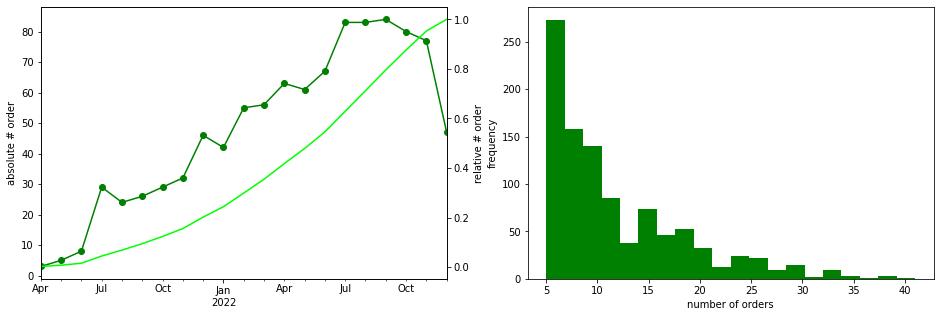

In [3]:
### PLOT ORDER FREQUENCY ###

monthlychurns = df.groupby('CustomerID')['InvoiceDate'].max() \
    .apply(lambda x: x.replace(day=1)).value_counts().sort_index()

true = monthlychurns.cumsum().to_dict()
eval_dates = pd.date_range(start=monthlychurns.index[0], end=end, freq='MS')

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
monthlychurns.plot(
    color='green', marker='o', ax=plt.gca()
)
plt.ylabel('absolute # order')
plt.twinx()
(monthlychurns.cumsum() / monthlychurns.sum()).plot(
    color='lime', ax=plt.gca()
)
plt.ylabel('relative # order')
plt.subplot(1,2,2)
df.groupby('CustomerID')['InvoiceDate'].count().plot(
    kind='hist', color='green', bins=20, ax=plt.gca()
)
plt.xlabel('number of orders'); plt.ylabel('frequency')
plt.show()

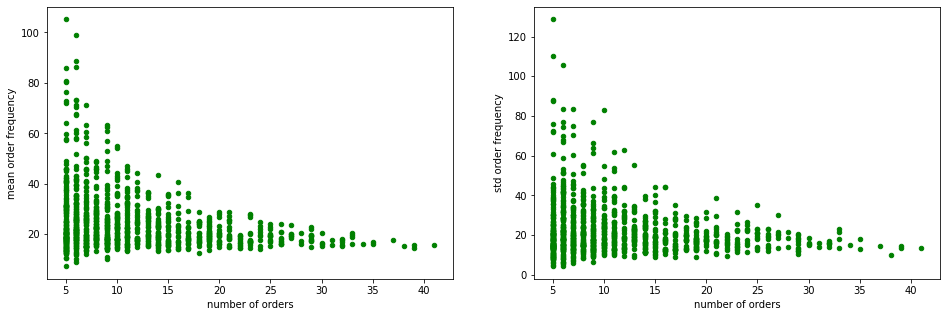

In [4]:
### PLOT NUMBER OF ORDERS vs MEAN/STD OF ORDER FREQUENCY ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
df.groupby('CustomerID')['InvoiceDateDiff'].agg(['mean','count']).plot.scatter(
    x='count', y='mean', color='green', ax=plt.gca()
)
plt.xlabel('number of orders'); plt.ylabel('mean order frequency')
plt.subplot(1,2,2)
df.groupby('CustomerID')['InvoiceDateDiff'].agg(['std','count']).plot.scatter(
    x='count', y='std', color='green', ax=plt.gca()
)
plt.xlabel('number of orders'); plt.ylabel('std order frequency')
plt.show()

In [5]:
### UTILITY FUNCTIONS TO PREDICT CHURN ###

def get_wtd_mean(vals, scores):

    num_order = np.floor(np.log10(scores.size)).astype(int)
    N = num_order - 1 if num_order else num_order

    inv_rng = 1 / (float('1e' + str(N)) + scores)
    inv_sum = np.sum(inv_rng)
    weights = inv_rng / inv_sum
        
    return np.average(vals, weights=weights)


def generate_norm(grp):
    
    low = grp['InvoiceDateDiff'].min()
    upp = grp['InvoiceDateDiff'].max()
    
    if 'Amount' in grp:
        scores = np.abs(grp['Amount'].values)
        mean = get_wtd_mean(grp['InvoiceDateDiff'], scores)
    else:
        mean = grp['InvoiceDateDiff'].mean()
    std = grp['InvoiceDateDiff'].std()

    trunc_norm = stats.truncnorm(
        (low - mean) / std,
        (upp - mean) / std,
        loc=mean, scale=std
    )

    return trunc_norm


def predict_by_cdf(
        grp, check_date,
        thr = 0.5, min_purch = 5,
    ):
    
    if len(grp) < min_purch:
        return np.nan
    else:
        nrd = generate_norm(grp)
        val = (check_date - grp['InvoiceDate'].max()).days
        return 1 if nrd.cdf(val) > thr else 0


def predict_by_sigma(
        grp, check_date,
        k = 3, min_purch = 5
    ):
    
    if len(grp) < min_purch:
        return np.nan
    else:  
        mnv = grp['InvoiceDateDiff'].mean()
        sdv = grp['InvoiceDateDiff'].std()
        val = (check_date - grp['InvoiceDate'].max()).days
        return 1 if val > mnv + (sdv * k) else 0  

In [6]:
### PREDICT CHURN OVER TIME ###

acc = {
    'pred_sigma': {},
    'pred_cdf_90': {},
    'pred_cdf_50': {},
}

prec = {
    'pred_sigma': {},
    'pred_cdf_90': {},
    'pred_cdf_50': {},
}

rec = {
    'pred_sigma': {},
    'pred_cdf_90': {},
    'pred_cdf_50': {},
}

for train_end in tqdm(eval_dates):
    
    df_train = df[(df['InvoiceDate'] < train_end)].copy()
    df_test = df[(df['InvoiceDate'] >= train_end)].copy()

    train_users = df_train['CustomerID'].unique()
    test_users = df_test['CustomerID'].unique()

    y = pd.Series(np.ones_like(train_users), index=train_users, dtype=int)
    y[y.index.isin(test_users)] = 0
    
    data_grouper = df_train.groupby('CustomerID', sort=False)
    
    df_pred = pd.DataFrame({
        'pred_sigma': data_grouper.apply(predict_by_sigma, 
                                         check_date=train_end),
        'pred_cdf_90': data_grouper.apply(predict_by_cdf, thr=0.9, 
                                           check_date=train_end),
        'pred_cdf_50': data_grouper.apply(predict_by_cdf, thr=0.5, 
                                           check_date=train_end),
        'true': y
    }).dropna()
    
    if not df_pred.empty and (df_pred['true'] > 0).any():
        
        cm = confusion_matrix(df_pred['true'], df_pred['pred_sigma'])
        acc['pred_sigma'][train_end] = cm[1,1] / true[train_end]
        prec['pred_sigma'][train_end] = cm[1,1] / (cm[0,1]+cm[1,1]) \
            if (cm[0,1]+cm[1,1]) > 0 else np.nan
        rec['pred_sigma'][train_end] = cm[1,1] / (cm[1,0]+cm[1,1]) \
            if (cm[1,0]+cm[1,1]) > 0 else np.nan
        cm = confusion_matrix(df_pred['true'], df_pred['pred_cdf_90'])
        acc['pred_cdf_90'][train_end] = cm[1,1] / true[train_end]
        prec['pred_cdf_90'][train_end] = cm[1,1] / (cm[0,1]+cm[1,1]) \
            if (cm[0,1]+cm[1,1]) > 0 else np.nan
        rec['pred_cdf_90'][train_end] = cm[1,1] / (cm[1,0]+cm[1,1]) \
            if (cm[1,0]+cm[1,1]) > 0 else np.nan
        cm = confusion_matrix(df_pred['true'], df_pred['pred_cdf_50'])
        acc['pred_cdf_50'][train_end] = cm[1,1] / true[train_end]
        prec['pred_cdf_50'][train_end] = cm[1,1] / (cm[0,1]+cm[1,1]) \
            if (cm[0,1]+cm[1,1]) > 0 else np.nan
        rec['pred_cdf_50'][train_end] = cm[1,1] / (cm[1,0]+cm[1,1]) \
            if (cm[1,0]+cm[1,1]) > 0 else np.nan

100%|██████████| 21/21 [00:49<00:00,  2.37s/it]


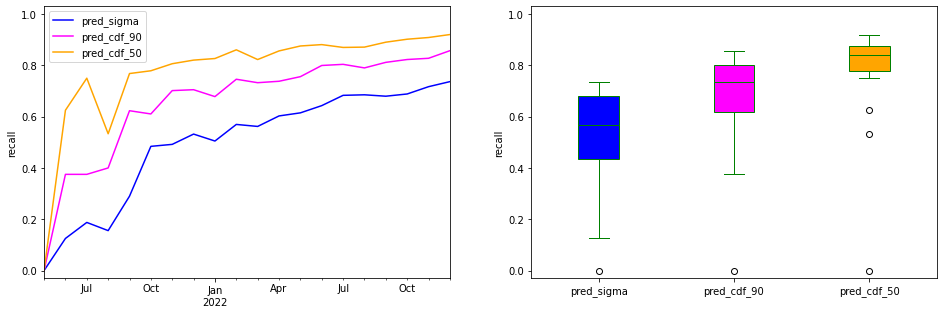

In [7]:
### RECALL PLOTS ###

plt.figure(figsize=(16,5))
_ = plt.subplot(1,2,1)
pd.DataFrame(rec).plot(ax=plt.gca(), color=['blue','magenta','orange'])
plt.ylim([-0.03,1.03]); plt.ylabel('recall')
ax = plt.subplot(1,2,2)
_,props = pd.DataFrame(rec).plot.box(patch_artist=True, color='green', return_type='both', ax=ax)
for patch,color in zip(props['boxes'],['blue','magenta','orange']):
    patch.set_facecolor(color)
plt.ylim([-0.03,1.03]); plt.ylabel('recall')
plt.show()

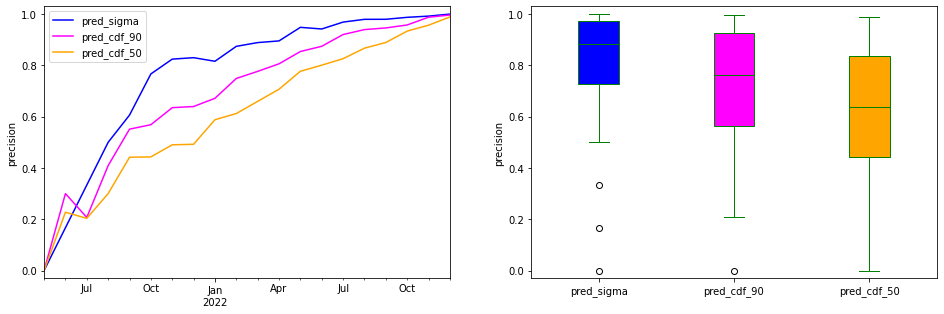

In [8]:
### PRECISION PLOTS ###

plt.figure(figsize=(16,5))
_ = plt.subplot(1,2,1)
pd.DataFrame(prec).plot(ax=plt.gca(), color=['blue','magenta','orange'])
plt.ylim([-0.03,1.03]); plt.ylabel('precision')
ax = plt.subplot(1,2,2)
_,props = pd.DataFrame(prec).plot.box(patch_artist=True, color='green', return_type='both', ax=ax)
for patch,color in zip(props['boxes'],['blue','magenta','orange']):
    patch.set_facecolor(color)
plt.ylim([-0.03,1.03]); plt.ylabel('precision')
plt.show()

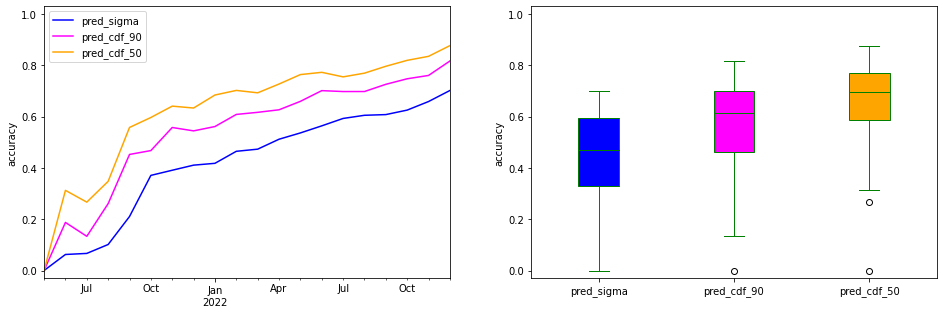

In [9]:
### ACCURACY PLOTS ###

plt.figure(figsize=(16,5))
_ = plt.subplot(1,2,1)
pd.DataFrame(acc).plot(ax=plt.gca(), color=['blue','magenta','orange'])
plt.ylim([-0.03,1.03]); plt.ylabel('accuracy')
ax = plt.subplot(1,2,2)
_,props = pd.DataFrame(acc).plot.box(patch_artist=True, color='green', return_type='both', ax=ax)
for patch,color in zip(props['boxes'],['blue','magenta','orange']):
    patch.set_facecolor(color)
plt.ylim([-0.03,1.03]); plt.ylabel('accuracy')
plt.show()